# Linear SVR for approximation of the fundamental matrices of image pairs
### to learn the ropes of the evaluation metric and establish our first (definitely bad) baseline model

## The general Task:

- The datasets are large and a baseline model which is not a neural network is definitely going to have a hard time here. We came up with the idea of applying an SVM to solve for the fundamental matrices of the image pairs.
- Due to the sheer size of the data (over 1.4 million pairings), the fact that for each pairing, a set of 2 images per pair (already resized by us to 150*150 px, resulting in 150x150 _px_ x3 _colors_ = 67500 features) and the fact that SVMs tend to become slower the larger the datasets become, we decided to only work with a small subsample of the data

In [1]:
{i/10 : (str(i/10) if i%2==0 else "") for i in range(0,11,1)}

{0.0: '0.0',
 0.1: '',
 0.2: '0.2',
 0.3: '',
 0.4: '0.4',
 0.5: '',
 0.6: '0.6',
 0.7: '',
 0.8: '0.8',
 0.9: '',
 1.0: '1.0'}

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import model
import validation
import matplotlib.pyplot as plt
import plotly.graph_objects as go

the list "scenes" tells the code, which scenes to load (see *list of all scenes* below)

In [2]:
input_dir = '../../data/train/' # directory of the training data

allscenes = ["british_museum", "brandenburg_gate", "buckingham_palace",
 "colosseum_exterior", "grand_place_brussels", "lincoln_memorial_statue",
 "notre_dame_front_facade", "pantheon_exterior", "piazza_san_marco",
 "sacre_coeur", "sagrada_familia", "st_pauls_cathedral", "st_peters_square",
 "taj_mahal", "temple_nara_japan", "trevi_fountain"]
scenes=allscenes
#scenes=["british_museum", "brandenburg_gate", "buckingham_palace","colosseum_exterior", "grand_place_brussels"]
#scenes=["temple_nara_japan"]



In [3]:
def load_pairs_and_cal(scenes, datadir):
    
    """
    load the image data from the correcsponding directory, together with the pairing metrics.
    Args:
        scenes:     List of scenes (folder names under /train)
        datadir:    String of the directory to source image data from

    Returns:
        pair: dataframe containing the image pairings
        calibration: dataframe contaaining the calibration data per image, including the corresponding scene
    """
    pair = pd.DataFrame()    
    calibration = pd.DataFrame()
    # path which contains all the categories of images
    j = 0
    for scene in scenes:
        print(f'loading category {j+1} of {len(scenes)}: {scene}')
        j += 1

        # read and concatenate pairing datasets. add the "scene" column.
        pairpath = os.path.join(datadir,scene,"pair_covisibility.csv")
        if pair.empty:
            pair = pd.read_csv(pairpath)
        else:
            pairappend = pd.read_csv(pairpath)
            pair = pd.concat([pair,pairappend],axis=0)

        # read and concatenate calibration data, add the "scene" column.
        calibrationpath = os.path.join(datadir,scene,"calibration.csv")
        if calibration.empty:
            calibration = pd.read_csv(calibrationpath)
            calibration["scene"] = str(scene)
        else:
            calibrationappend = pd.read_csv(calibrationpath)
            calibrationappend["scene"] = str(scene)
            calibration = pd.concat([calibration,calibrationappend],axis=0)

    return pair, calibration

In [4]:
pairings, calibration = load_pairs_and_cal(scenes,input_dir)
scalings = pd.read_csv(os.path.join(input_dir, "scaling_factors.csv"))


loading category 1 of 16: british_museum
loading category 2 of 16: brandenburg_gate
loading category 3 of 16: buckingham_palace
loading category 4 of 16: colosseum_exterior
loading category 5 of 16: grand_place_brussels
loading category 6 of 16: lincoln_memorial_statue
loading category 7 of 16: notre_dame_front_facade
loading category 8 of 16: pantheon_exterior
loading category 9 of 16: piazza_san_marco
loading category 10 of 16: sacre_coeur
loading category 11 of 16: sagrada_familia
loading category 12 of 16: st_pauls_cathedral
loading category 13 of 16: st_peters_square
loading category 14 of 16: taj_mahal
loading category 15 of 16: temple_nara_japan
loading category 16 of 16: trevi_fountain


In [7]:
calibration

image_id                                  camera_intrinsics  \
0    96255967_5091378744  8.59689453e+02 0.00000000e+00 5.35500000e+02 0...   
1     42219277_428722452  8.44582458e+02 0.00000000e+00 5.31000000e+02 0...   
2     10725166_210986135  5.28298767e+02 0.00000000e+00 2.56000000e+02 0...   
3    50084748_4116974413  1.16656165e+03 0.00000000e+00 5.30500000e+02 0...   
4    66393650_5300086486  9.91861450e+02 0.00000000e+00 5.10000000e+02 0...   
..                   ...                                                ...   
701  02581730_8151291160  8.56864014e+02 0.00000000e+00 3.47000000e+02 0...   
702  40184297_2989394429  1.06278186e+03 0.00000000e+00 3.89000000e+02 0...   
703  45028253_4526518169  7.44483643e+02 0.00000000e+00 1.02000000e+02 0...   
704  66225128_7739308762  7.84798523e+02 0.00000000e+00 3.37000000e+02 0...   
705   91266839_729663994  1.00914203e+03 0.00000000e+00 5.23500000e+02 0...   

                                       rotation_matrix  \
0    9.99891678e-01 -1.33539542e-02 6.18909449e-03 ...   
1    9.97685713e-01 -1.30963354e-02 6.67210940e-02 ...   
2    9.98152782e-01 -3.16456041e-02 5.18611653e-02 ...   
3    9.99766659e-01 -1.90689108e-02 -1.01491435e-02...   
4    9.98476842e-01 -1.77581448e-02 5.22364245e-02 ...   
..                                                 ...   
701  9.90124897e-01 -4.71174648e-02 -1.32032697e-01...   
702  9.99936906e-01 -8.32179083e-03 -7.54537654e-03...   
703  9.98800080e-01 -3.12105707e-02 -3.77399081e-02...   
704  9.91486213e-01 1.07817217e-02 -1.29764574e-01 ...   
705  9.33916844e-01 -2.95706088e-01 2.00891112e-01 ...   

                                  translation_vector           scene  
0    -6.30413738e-01 -2.09383535e-01 -9.73421015e-01  british_museum  
1      -2.37605901e+00 2.88211093e-01 2.70707623e+00  british_museum  
2      -2.27119169e+00 6.73166892e-02 1.84570935e+00  british_museum  
3      -6.63296507e-01 1.45779139e-01 4.57227935e-01  british_museum  
4    -2.83293685e+00 -5.72882855e-03 -2.83308355e-01  british_museum  
..                                               ...             ...  
701     1.03693602e+00 5.61571480e-02 9.84726727e-02  trevi_fountain  
702   1.05185800e-01 -1.05518102e+00 -1.35282347e+00  trevi_fountain  
703     3.51829579e-01 1.70568331e+00 6.31627688e+00  trevi_fountain  
704   1.20354727e+00 -8.15005057e-01 -1.11283145e+00  trevi_fountain  
705  -9.07333027e-01 -5.78619449e-01 -1.78706699e-01  trevi_fountain  

[5678 rows x 5 columns]

In [6]:
pairings

pair  covisibility  \
0       93658023_4980549800-77723525_5227836172         0.852   
1       93658023_4980549800-42803655_6429621523         0.846   
2       77723525_5227836172-69960354_6519615529         0.819   
3       77723525_5227836172-42803655_6429621523         0.823   
4        19254317_158538587-18486676_4996206525         0.813   
...                                         ...           ...   
248860  61223743_3150830063-49526651_4313316394         0.000   
248861  61223743_3150830063-57483850_8143888888         0.065   
248862  61356448_1422536267-45193054_8818019758         0.045   
248863  61356448_1422536267-51302065_4767762595         0.087   
248864  61356448_1422536267-57483850_8143888888         0.080   

                                       fundamental_matrix  
0       1.06093615e-03 9.46438466e-02 -5.40808291e+01 ...  
1       6.23570537e-03 -1.34283767e+00 6.89519259e+02 ...  
2       -1.08832894e-01 -4.38808860e+00 2.62340512e+03...  
3       3.66899294e-03 -2.00963144e+00 1.04914787e+03 ...  
4       3.02953840e-03 3.28935263e-01 -8.58941061e+01 ...  
...                                                   ...  
248860  -3.11287848e-01 -3.78785669e+00 1.90332228e+03...  
248861  -6.03911030e-01 -5.88136724e+00 3.19475581e+03...  
248862  9.15015123e-01 -9.16312393e+00 7.88887558e+03 ...  
248863  -3.15207536e-02 -1.51219066e+00 1.58840706e+03...  
248864  2.08778868e-01 -6.30007290e+00 7.01434119e+03 ...  

[1416814 rows x 3 columns]

In [7]:
scalings

scene  scaling_factor
0            british_museum           2.517
1          brandenburg_gate           7.380
2         buckingham_palace          18.750
3        colosseum_exterior          36.990
4      grand_place_brussels          10.260
5   lincoln_memorial_statue           1.850
6   notre_dame_front_facade           1.360
7         pantheon_exterior           5.410
8          piazza_san_marco           7.920
9               sacre_coeur          20.270
10          sagrada_familia           4.200
11       st_pauls_cathedral           7.010
12         st_peters_square          21.480
13                taj_mahal          20.760
14        temple_nara_japan           7.790
15           trevi_fountain           3.670

In [8]:
K = np.array(calibration.iloc[0,1].split()).reshape(3,3).astype(float)
R = np.array(calibration.iloc[0,2].split()).reshape(3,3).astype(float)
T = np.array(calibration.iloc[0,3].split()).reshape(3,1).astype(float)

In [9]:
def plot_3D_perspective_in_2D(R,T, scene="", scale = 1, color=None, alpha = 1):
    if scene != "":
        scale = scalings.query("scene == @scene")["scaling_factor"]
    position = np.dot(-R.T, T)
    rotation = R.T
    C_x = position[0]*scale
    C_y = position[1]*scale
    C_z = position[2]*scale
    # R_x = np.arctan2(rotation[2][1], rotation[2][2])*-180/np.pi
    R_y = np.arctan2(-rotation[2][0], np.sqrt((rotation[2][1]**2)+(rotation[2][2]**2)))*-180/np.pi
    # R_z = np.arctan2(rotation[1][0], rotation[0][0])*-180/np.pi
    return plt.plot(C_x, C_z, marker=(2, 1, R_y), markersize=20, linestyle='None', color=color, alpha=alpha)



In [10]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

In [11]:
def plot_camera_positions(Rs, Ts, img_IDs=0, images=0, scene="", scenes=scenes, scalings = pd.read_csv(os.path.join('../../data/train/', "scaling_factors.csv")), cmap="Blues", opacity = 1):
    scale = 1
    if scene != "":
        scale = scalings.query("scene == @scene")["scaling_factor"]
    C_x = []
    C_y = []
    C_z = []
    R_x = []
    R_y = []
    R_z = []
    for R,T in zip(Rs,Ts):
        position = np.dot(-R.T, T)
        rotation = R.T
        C_x.append(float(position[0]*scale))
        C_y.append(float(position[1]*scale))
        C_z.append(float(position[2]*scale))
        # R_x.append(np.arctan2(rotation[2][1], rotation[2][2])*-180/np.pi)
        R_y.append(np.arctan2(-rotation[2][0], np.sqrt((rotation[2][1]**2)+(rotation[2][2]**2))))
        # R_z.append(np.arctan2(rotation[1][0], rotation[0][0])*-180/np.pi)
    angles = R_y
    arrowscale = np.mean([max(C_x)-min(C_x),max(C_y)-min(C_y)])*0.1
    
    x_dir = [-float(arrowscale)*np.sin(angle) + x for angle, x in zip(angles, C_x)]
    y_dir = [-float(arrowscale)*np.cos(angle) + y for angle, y in zip(angles, C_z)]
    # Build figure
    fig = make_subplots(rows= 4, cols = 4, subplot_titles=[s.replace("_", " ") for s in scenes])
    fig.update_yaxes(
        scaleanchor = "x",
        scaleratio = 1,
    )
    hover_dicts = [
        {
                "hovertemplate": 
                "X: %{x},<br> Y: %{y}<extra></extra>",
        },
        {
                "hoverinfo": 'skip',
        }
    ]
    for x_, y_, s, c, line_c, hover in [(C_x, C_z, 0, 'LightSkyBlue', 'blue', hover_dicts[0]), (x_dir, y_dir, 0, 'red', 'red', hover_dicts[1])]:
        fig.add_trace(
            go.Scatter(
                mode='markers',
                x = x_,
                y = y_,
                marker=dict(
                    size = s,
                    opacity = 1,
                    color = "LightSkyBlue",
                    line = dict(
                        color = "black",
                        width = 2,
                    ),
                    symbol = "circle-dot"
                ),
                showlegend = False,
                **hover
            )
        )
    col = iter(plt.cm.Blues(np.linspace(0.01, 0.99, len(C_x))))
    for x_, y_, x_d, y_d in zip(C_x, C_z, x_dir, y_dir):
        fig.add_annotation(
            x=x_,  # arrows' head
            y=y_,  # arrows' head
            ax=x_d,  # arrows' tail
            ay=y_d,  # arrows' tail
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            text='',  # if you want only the arrow
            showarrow=True,
            opacity = opacity,
            arrowhead=3,
            arrowsize=1,
            arrowwidth=3,
            arrowcolor=str(list(next(col))).replace("[","rgba(").replace("]",")")
            )
    #fig.update_layout(height=600, width=800, title_text=scene.replace("_", " "))
    fig.show()


In [ ]:
# def plot_camera_positions(Rs, Ts, img_IDs=0, images=0, scene="", scalings = pd.read_csv(os.path.join('../../data/train/', "scaling_factors.csv")), cmap="Blues", opacity = 1):
#     scale = 1
#     if scene != "":
#         scale = scalings.query("scene == @scene")["scaling_factor"]
#     C_x = []
#     C_y = []
#     C_z = []
#     R_x = []
#     R_y = []
#     R_z = []
#     for R,T in zip(Rs,Ts):
#         position = np.dot(-R.T, T)
#         rotation = R.T
#         C_x.append(float(position[0]*scale))
#         C_y.append(float(position[1]*scale))
#         C_z.append(float(position[2]*scale))
#         # R_x.append(np.arctan2(rotation[2][1], rotation[2][2])*-180/np.pi)
#         R_y.append(np.arctan2(-rotation[2][0], np.sqrt((rotation[2][1]**2)+(rotation[2][2]**2))))
#         # R_z.append(np.arctan2(rotation[1][0], rotation[0][0])*-180/np.pi)
#     angles = R_y
#     arrowscale = np.mean([max(C_x)-min(C_x),max(C_y)-min(C_y)])*0.1
    
#     x_dir = [-float(arrowscale)*np.sin(angle) + x for angle, x in zip(angles, C_x)]
#     y_dir = [-float(arrowscale)*np.cos(angle) + y for angle, y in zip(angles, C_z)]
#     # Build figure
#     fig = go.figure()
#     fig.update_yaxes(
#         scaleanchor = "x",
#         scaleratio = 1,
#     )
#     hover_dicts = [
#         {
#                 "hovertemplate": 
#                 "X: %{x},<br> Y: %{y}<extra></extra>",
#         },
#         {
#                 "hoverinfo": 'skip',
#         }
#     ]
#     for x_, y_, s, c, line_c, hover in [(C_x, C_z, 0, 'LightSkyBlue', 'blue', hover_dicts[0]), (x_dir, y_dir, 0, 'red', 'red', hover_dicts[1])]:
#         fig.add_trace(
#             go.Scatter(
#                 mode='markers',
#                 x = x_,
#                 y = y_,
#                 marker=dict(
#                     size = s,
#                     opacity = 1,
#                     color = "LightSkyBlue",
#                     line = dict(
#                         color = "black",
#                         width = 2,
#                     ),
#                     symbol = "circle-dot"
#                 ),
#                 showlegend = False,
#                 **hover
#             )
#         )
#     col = iter(plt.cm.Blues(np.linspace(0.01, 0.99, len(C_x))))
#     for x_, y_, x_d, y_d in zip(C_x, C_z, x_dir, y_dir):
#         fig.add_annotation(
#             x=x_,  # arrows' head
#             y=y_,  # arrows' head
#             ax=x_d,  # arrows' tail
#             ay=y_d,  # arrows' tail
#             xref='x',
#             yref='y',
#             axref='x',
#             ayref='y',
#             text='',  # if you want only the arrow
#             showarrow=True,
#             opacity = opacity,
#             arrowhead=3,
#             arrowsize=1,
#             arrowwidth=3,
#             arrowcolor=str(list(next(col))).replace("[","rgba(").replace("]",")")
#             )
#     fig.update_layout(height=600, width=800, title_text=scene.replace("_", " "))
#     fig.show()


In [12]:

for i, scene in enumerate(scenes):
    # construct scene-specific lists of calibration factors, rotational matrices and translational vectors.
    cal = calibration.query("scene == @scene")
    Rs = [np.array(cal.iloc[i,2].split()).reshape(3,3).astype(float) for i in range(cal.shape[0])]
    Ts = [np.array(cal.iloc[i,3].split()).reshape(3,1).astype(float) for i in range(cal.shape[0])]

    plot_camera_positions(Rs,Ts,scene=scene)


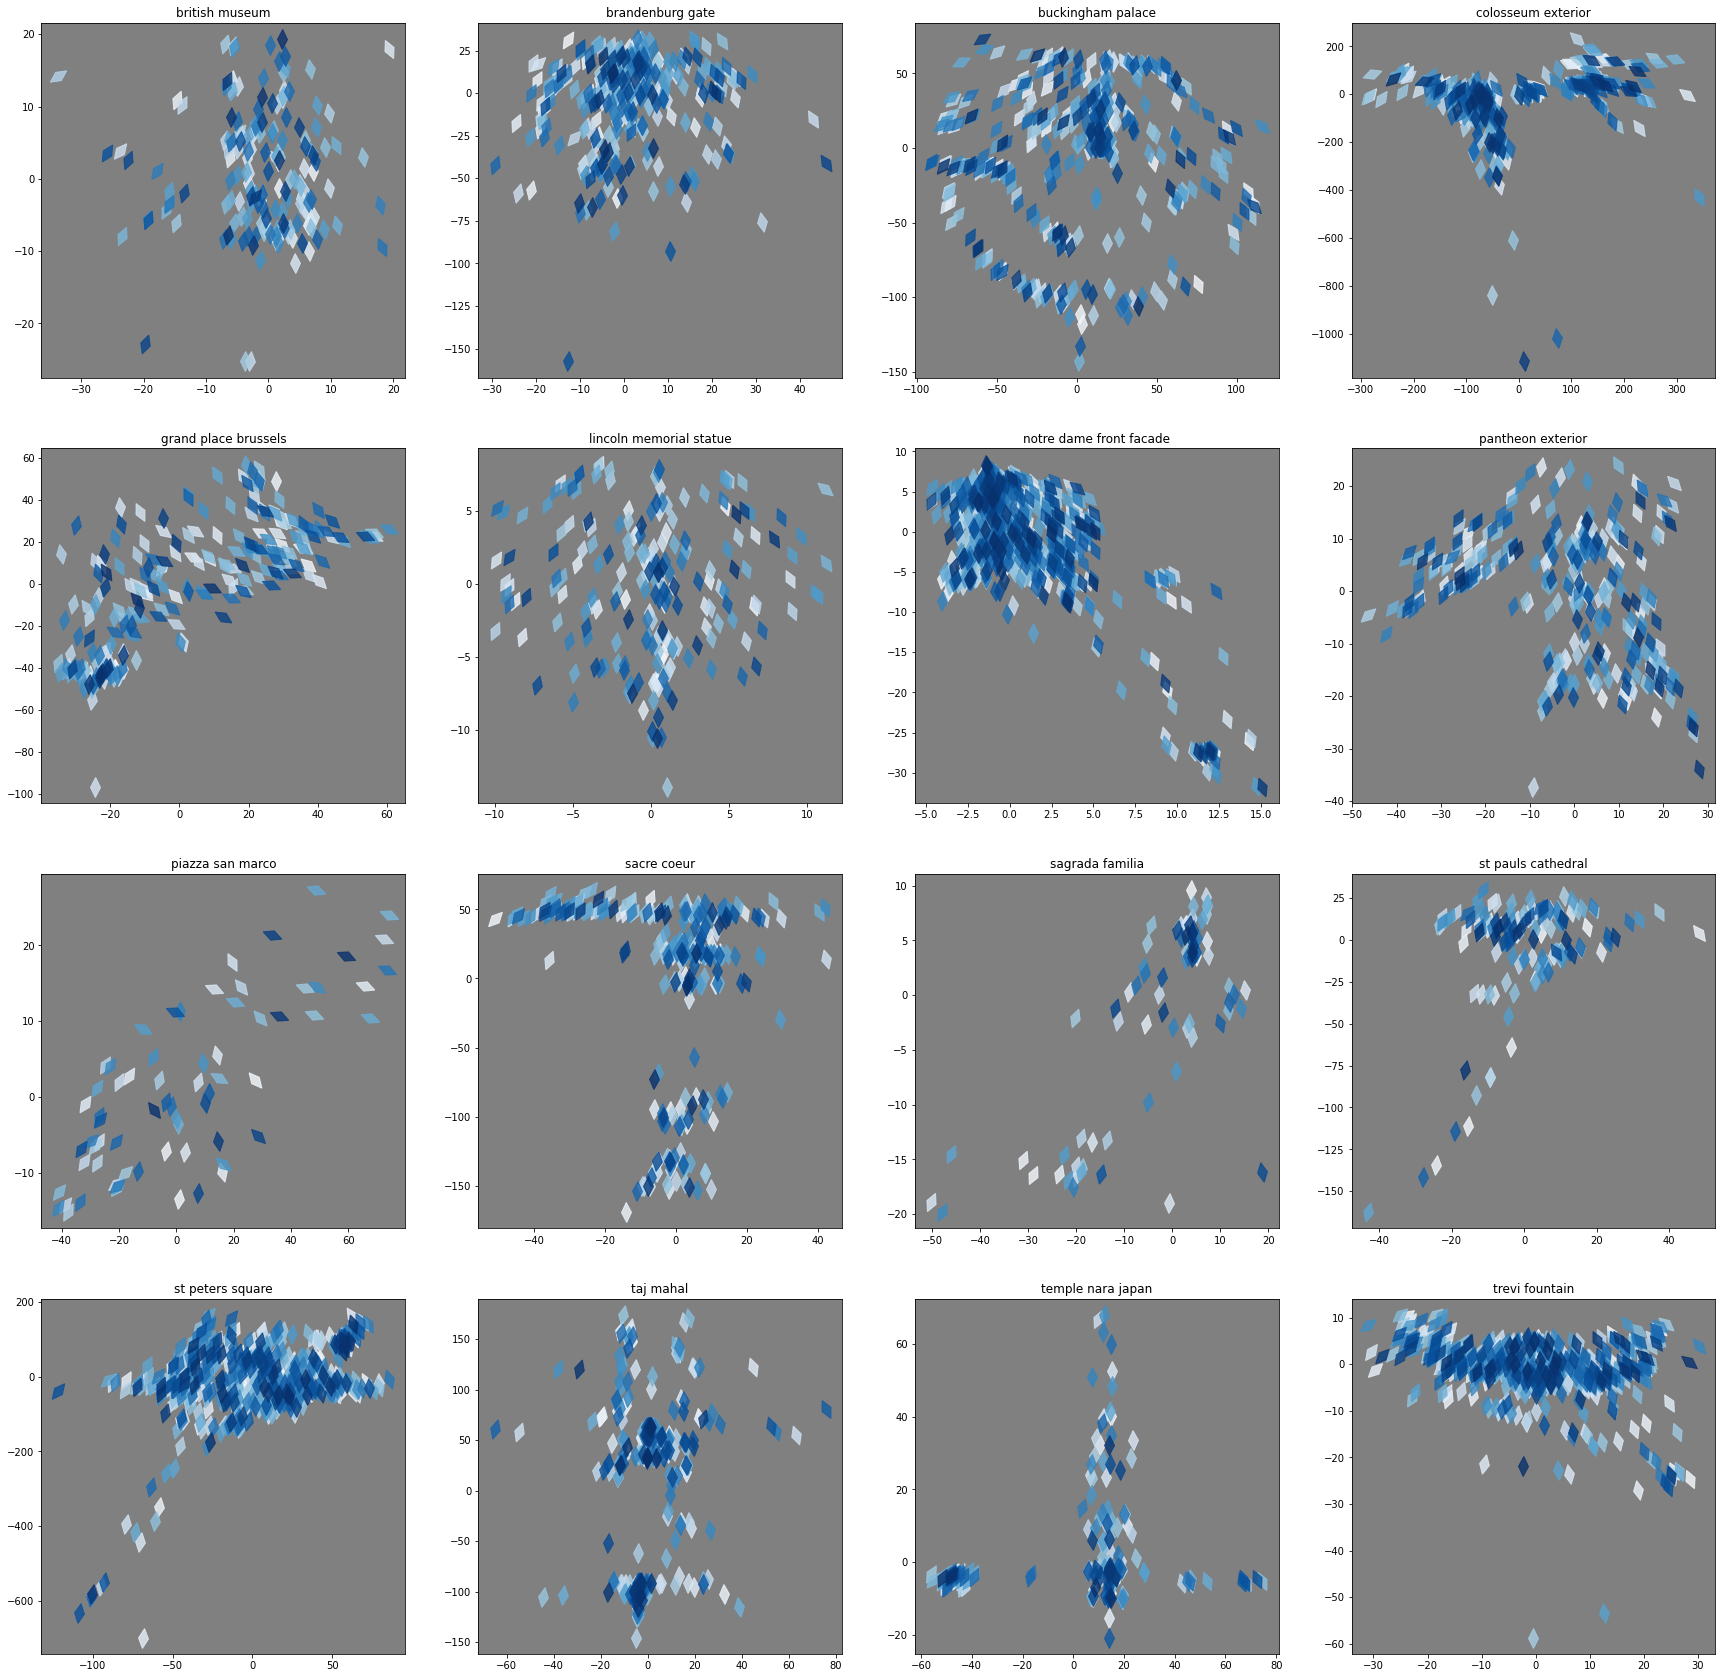

In [13]:
plt.figure(figsize=[30,30])
for i, scene in enumerate(scenes):
    # construct scene-specific lists of calibration factors, rotational matrices and translational vectors.
    cal = calibration.query("scene == @scene")
    Rs = [np.array(cal.iloc[i,2].split()).reshape(3,3).astype(float) for i in range(cal.shape[0])]
    Ts = [np.array(cal.iloc[i,3].split()).reshape(3,1).astype(float) for i in range(cal.shape[0])]

    sp = plt.subplot(4,4,i+1)
    sp.set_facecolor("grey")
    sp.set_title(scene.replace("_", " "))
    col = iter(plt.cm.Blues(np.linspace(0, 1, cal.shape[0])))
    for R,T in zip(Rs,Ts):
        plot_3D_perspective_in_2D(R,T, scene=scene, color=next(col), alpha = 0.8)
plt.show()